# MountainCar-v0-Cross-Entropy Method
Implement of a corss-entropy method in policy-based methods

### Import Necessary Packages

In [1]:
import gym
import math
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

!python -m pip install pyvirtualdisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400,900))
display.start()

is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

### Specify the Environment, and Explore the State and Action spaces


In [2]:
# Create an environment and set random seed
env = gym.make('MountainCarContinuous-v0')
env.seed(101)
np.random.seed(101)



In [3]:
# Explore state (observation) space
# state: [position, speed]
print('observation space: ', env.observation_space)
print(' -low: ', env.observation_space.low)
print(' -high: ', env.observation_space.high)

# Explore the action space
# action [action]
print('action space: ', env.action_space)
print(' -low: ', env.action_space.low)
print(' -high: ', env.action_space.high)

observation space:  Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
 -low:  [-1.2  -0.07]
 -high:  [0.6  0.07]
action space:  Box([-1.], [1.], (1,), float32)
 -low:  [-1.]
 -high:  [1.]


### Watch a random agent

Score:  999


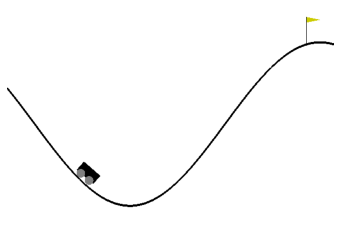

In [4]:
state = env.reset()
img = plt.imshow(env.render(mode='rgb_array'))
for t in range(1000):
    action = env.action_space.sample()
    img.set_data(env.render(mode='rgb_array'))
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    state, reward, done, _ = env.step(action)
    if done:
        print('Score: ', t+1)
        break

env.close()

## Train an agent to perfrom better.

Explore the state and action spaces, as well as sample them.

In [5]:
# Explore state (observation) space
# state: [position, speed]
print('Observation space: ', env.observation_space)
print('state shape: ', env.observation_space.shape)
print(' -low: ', env.observation_space.low)
print(' -high: ', env.observation_space.high)
# Generate some samples from the state space 
print("State space samples:")
print(np.array([env.observation_space.sample() for i in range(10)]))

print("\n\n")

# Explore the action space
# action [action]
print('Action space: ', env.action_space)
print('action shape: ', env.action_space.shape)
print(' -low: ', env.action_space.low)
print(' -high: ', env.action_space.high)
# Generate some samples from the action space
print("Action space samples:")
print(np.array([env.action_space.sample() for i in range(10)]))


Observation space:  Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
state shape:  (2,)
 -low:  [-1.2  -0.07]
 -high:  [0.6  0.07]
State space samples:
[[-0.30670425  0.06603958]
 [-0.15175831 -0.03713643]
 [-0.5649248  -0.02363089]
 [ 0.5595818  -0.04409696]
 [-0.5084649   0.05890182]
 [ 0.30128193  0.06887893]
 [ 0.27741018  0.00126783]
 [-0.13336651 -0.0424035 ]
 [-0.51184523  0.0341886 ]
 [ 0.05956766  0.0532283 ]]



Action space:  Box([-1.], [1.], (1,), float32)
action shape:  (1,)
 -low:  [-1.]
 -high:  [1.]
Action space samples:
[[-0.3601283 ]
 [ 0.79807544]
 [ 0.09698661]
 [ 0.28053644]
 [-0.51310056]
 [ 0.2777974 ]
 [ 0.00765343]
 [ 0.09583376]
 [ 0.9308967 ]
 [ 0.7934322 ]]


# Instantiate the Agent

View this tensor as the same size as other. self.view_as(other) is equivalent to self.view(other.size()).


In [6]:
class Agent(nn.Module):
    def __init__(self, env, h_size=16):
        super(Agent, self).__init__()
        self.env = env
        # state, hidden_layer, action sizes
        self.s_size = env.observation_space.shape[0]    # state_size
        self.h_size = h_size
        self.a_size = env.action_space.shape[0]         # action_size
        
        # Define layer
        self.fc1 = nn.Linear(self.s_size, self.h_size)
        self.fc2 = nn.Linear(self.h_size, self.a_size)
        
    def set_weights(self, weights):
        s_size = self.s_size
        h_size = self.h_size
        a_size = self.a_size
        
        
        # Separate the weights for each layer---
        # Writing to a tensor created from a read-only NumPy array
        # fc1: weight and bias resize
        fc1_end = (s_size * h_size) + h_size
        fc1_W = torch.from_numpy(weights[:s_size*h_size].reshape(s_size, h_size))
        fc1_b = torch.from_numpy(weights[s_size*h_size:fc1_end])
        
        # fc2: weight and bias resize
        fc2_W = torch.from_numpy(weights[fc1_end:fc1_end+(h_size*a_size)].reshape(h_size, a_size))
        fc2_b = torch.from_numpy(weights[fc1_end+(h_size*a_size):])
        
        # set the weights for each layer
        self.fc1.weight.data.copy_(fc1_W.view_as(self.fc1.weight.data))
        self.fc1.bias.data.copy_(fc1_b.view_as(self.fc1.bias.data))
        self.fc2.weight.data.copy_(fc2_W.view_as(self.fc2.weight.data))
        self.fc2.bias.data.copy_(fc2_b.view_as(self.fc2.bias.data))
        # ---
        

    def get_weights_dim(self):
        return (self.s_size + 1) * self.h_size + (self.h_size + 1) * self.a_size

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.tanh(self.fc2(x))                   # [-1, 1] use tanh
        return x.cpu().data

    def evaluate(self, weights, gamma=1.0, max_t=5000):
        self.set_weights(weights)
        episode_return = 0.0
        state = self.env.reset()
        for t in range(max_t):
            state = torch.from_numpy(state).float().to(device)
            action = self.forward(state)          # action from state
            state, reward, done, _ = self.env.step(action)
            episode_return += reward * math.pow(gamma, t)
            if done:
                break
        return episode_return
        

In [7]:
# Set torch device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

agent = Agent(env).to(device)

# Train the Agent with Cross-Entropy Method


/home/eight/anaconda3/envs/torchunity/lib/python3.6/site-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 10	Average Score: -1.68
Episode 20	Average Score: -1.84
Episode 30	Average Score: -1.66
Episode 40	Average Score: -1.57
Episode 50	Average Score: -1.37
Episode 60	Average Score: -1.21
Episode 70	Average Score: -1.15
Episode 80	Average Score: -1.03
Episode 90	Average Score: -0.99
Episode 100	Average Score: -0.93
Episode 110	Average Score: 7.60
Episode 120	Average Score: 17.15
Episode 130	Average Score: 26.71
Episode 140	Average Score: 36.30
Episode 150	Average Score: 45.86
Episode 160	Average Score: 55.28
Episode 170	Average Score: 64.70
Episode 180	Average Score: 74.10
Episode 190	Average Score: 83.57

Environment solved in 97 iterations!	Average Score: 90.14


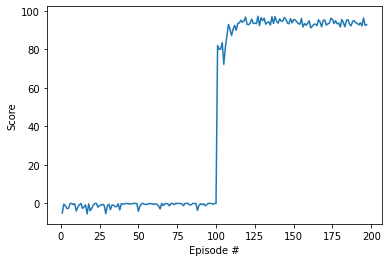

In [8]:
def crossEntropyMethod(n_iterations=500, max_t=1000, gamma=1.0, print_every=10, pop_size=50, elite_frac=0.2, sigma=0.5):
    """
    Implement cross-entropy method
    
    Params
    ======
        n_iterations (int): maximum number of training iterations
        max_t (int): maximum nuber of timesteps per episode
        gamma (float): discount rate
        print_every (int): how often to print average score (over last 100 episodes)
        pop_size (int): size of population at each iteration
        elite_frac (float): percentage of top performers to use in update
        sigma (float): standard deviation of additive noise
    """
    
    n_elite = int(pop_size * elite_frac)
    
    scores_deque = deque(maxlen=100)
    scores = []
    best_weight = sigma * np.random.randn(agent.get_weights_dim())      # initialize parameters
    
    for i_iteration in range(1, n_iterations+1):
        weights_pop = [best_weight + (sigma * np.random.randn(agent.get_weights_dim())) for i in range(pop_size)]
        rewards = np.array([agent.evaluate(weights, gamma, max_t) for weights in weights_pop])
        
        elite_idxs = rewards.argsort()[-n_elite:]
        elite_weights = [weights_pop[i] for i in elite_idxs]
        best_weight = np.array(elite_weights).mean(axis=0)
        
        reward = agent.evaluate(best_weight, gamma=1.0)
        scores_deque.append(reward)
        scores.append(reward)
        
        
        # Checkpint
        torch.save(agent.state_dict(), 'checkpoint.pth')
        
        # Monitor
        if i_iteration % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_iteration, np.mean(scores_deque)))

        if np.mean(scores_deque)>=90.0:
            print('\nEnvironment solved in {:d} iterations!\tAverage Score: {:.2f}'.format(i_iteration-100, np.mean(scores_deque)))
            break
    return scores

scores = crossEntropyMethod()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

# Simulate Trained Agent


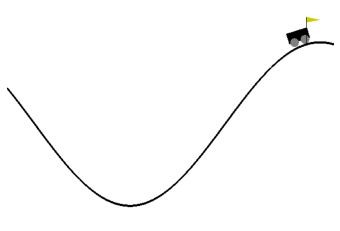

In [61]:
# load the weights from file
agent.load_state_dict(torch.load('checkpoint.pth'))

state = env.reset()
img = plt.imshow(env.render(mode='rgb_array'))
while True:
    state = torch.from_numpy(state).float().to(device)
    with torch.no_grad():
        action = agent(state)
#     action = env.action_space.sample()
    img.set_data(env.render(mode='rgb_array'))
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    next_state, reward, done, _ = env.step(action)
    state = next_state
    if done:
#         print('Score: ', t+1)
        break

env.close()